In [ ]:
# Mouting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Background Handlers

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [ ]:
def crop(image):
  cropped = image[0:605, 0:1024]
  return cropped

def kmeansColorQuantization(image, clusters=8, rounds=1):
    h, w = image.shape[:2]
    samples = np.zeros([h*w,3], dtype=np.float32)
    count = 0

    for x in range(h):
        for y in range(w):
            samples[count] = image[x][y]
            count += 1

    compactness, labels, centers = cv2.kmeans(samples,
            clusters,
            None,
            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001),
            rounds,
            cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    return res.reshape((image.shape))

def process(image, toCrop):
  cropped = image.copy()
  if toCrop:
    cropped = crop(image)
  original = cropped.copy()

  colorQuantisedImage = kmeansColorQuantization(cropped, clusters=2) # kmeans quantisation of image colors
  grayscaleImage = cv2.cvtColor(colorQuantisedImage, cv2.COLOR_BGR2GRAY) # conversion to Black and White grayscale
  thresholdedImage = cv2.threshold(grayscaleImage, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1] # Otsu thresholding of image

  # Find contours, remove tiny specs using contour area filtering, gather points
  pointsList = []
  sizeList = []
  contours, _ = cv2.findContours(thresholdedImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
  AREA_THRESHOLD = 2
  for c in contours:
      area = cv2.contourArea(c)
      if area < AREA_THRESHOLD:
          cv2.drawContours(thresholdedImage, [c], -1, 0, -1)
      else:
          (x, y), radius = cv2.minEnclosingCircle(c)
          pointsList.append((int(x), int(y)))
          sizeList.append(area)

  # Apply threshold mask onto original image
  result = cv2.bitwise_and(original, original, mask=thresholdedImage)
  result[thresholdedImage == 255] = (36,255,12)

  # Overlay on original
  original[thresholdedImage == 255] = (36,255,12)

  print("Number of particles: {}".format(len(pointsList)))
  print("Average particle size: {:.3f}".format(sum(sizeList)/len(sizeList)))

  imagesList = [image, cropped, result]

  return imagesList, pointsList, sizeList

def display(imagesList):
  for image in imagesList:
    cv2_imshow(image)

def findClass(imageName):
  image = tf.keras.utils.load_img(
      imageName, target_size=(224, 224)
  )
  normalisation_layer = tf.keras.layers.Rescaling(1./255)
  image = normalisation_layer(image)
  imageArray = tf.expand_dims(tf.keras.utils.img_to_array(image), 0)
  predictions = model.predict(imageArray)
  score = tf.nn.softmax(predictions[0])
  plt.imshow(image)

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(classNames[np.argmax(score)], 100 * np.max(score))
  )

In [ ]:
classNames = ['Biological', 'Fibres', 'Films_Coated_Surface', 'MEMS_devices_and_electrodes', 'Nanowires', 'Particles', 'Patterned_surface', 'Porous_Sponge', 'Powder', 'Tips']
modelPath = "/content/drive/MyDrive/SEMProject/SEM100/models/finalModels/NamamOptimser_LabelEncoded_simpleTransferLearning_MobileNetV2_rgb_notCropped_augemnted_learningRateReduction10x_seed108_restDefault.h5"

In [ ]:
model = tf.keras.models.load_model(
       (modelPath),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

# Frontline Inference

1/1 [==============================] - 2s 2s/step
This image most likely belongs to Biological with a 81.96 percent confidence.


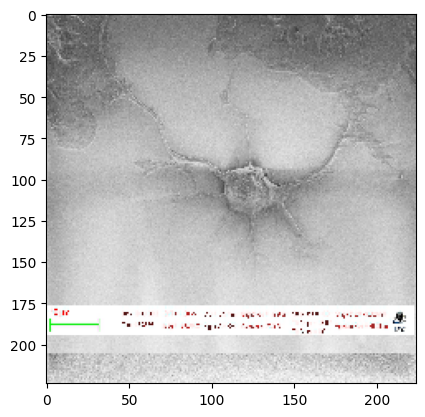

In [ ]:
findClass("/content/drive/MyDrive/SEMProject/SEM500/test/Biological/L7_1ba7dd7091d1c6874590c36ff73f328a.jpg")

1/1 [==============================] - 0s 62ms/step
This image most likely belongs to Porous_Sponge with a 98.74 percent confidence.


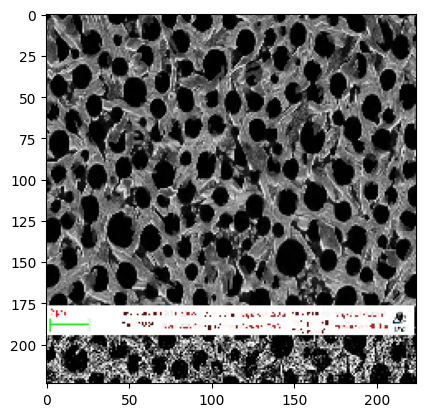

In [ ]:
findClass("/content/drive/MyDrive/SEMProject/SEM500/test/Porous_Sponge/L0_6ae4f6e4b367192eb175a5aa1a0f0281.jpg")

1/1 [==============================] - 0s 89ms/step
This image most likely belongs to Particles with a 91.25 percent confidence.


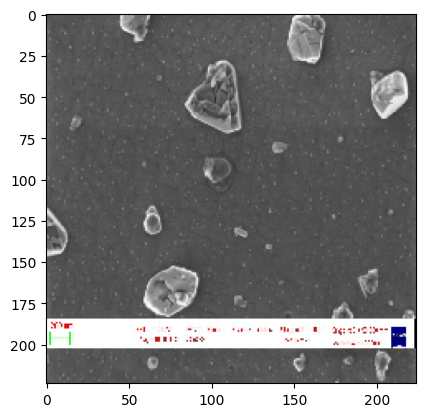

In [ ]:
findClass("/content/drive/MyDrive/SEMProject/SEM500/test/Particles/L2_0e4482cf13af98a0e9a13b23406fd832.jpg")

In [ ]:
particle = cv2.imread('/content/drive/MyDrive/SEMProject/SEM500/test/Particles/L2_0e4482cf13af98a0e9a13b23406fd832.jpg')

Number of particles: 111
Average particle size: 353.212


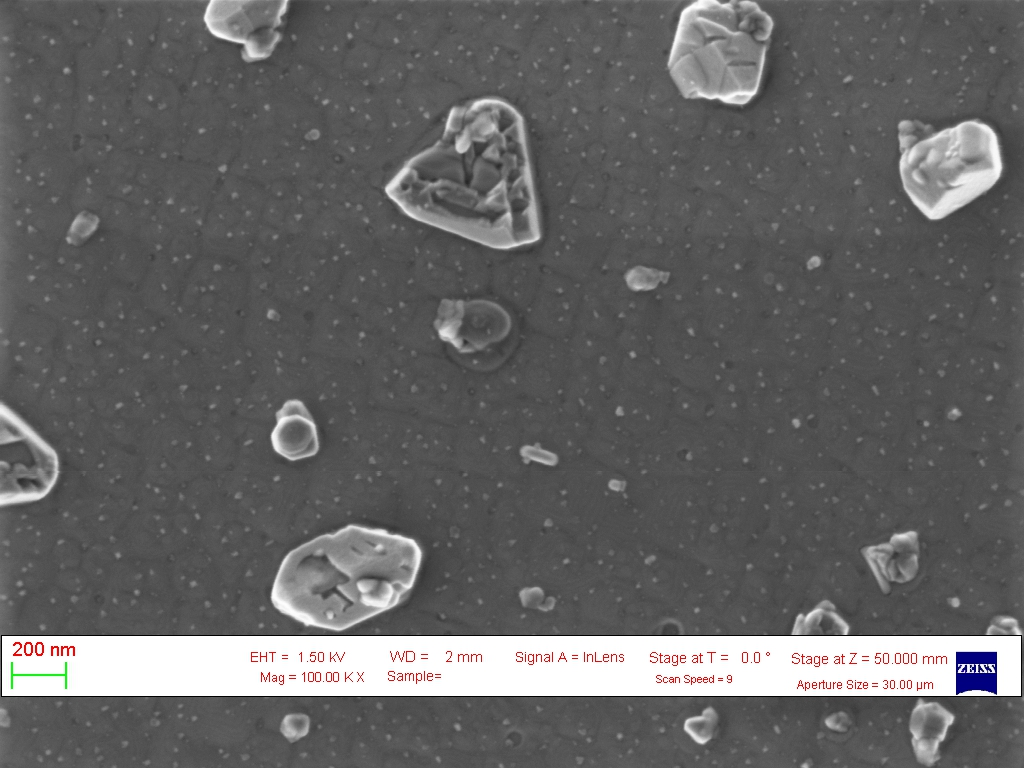

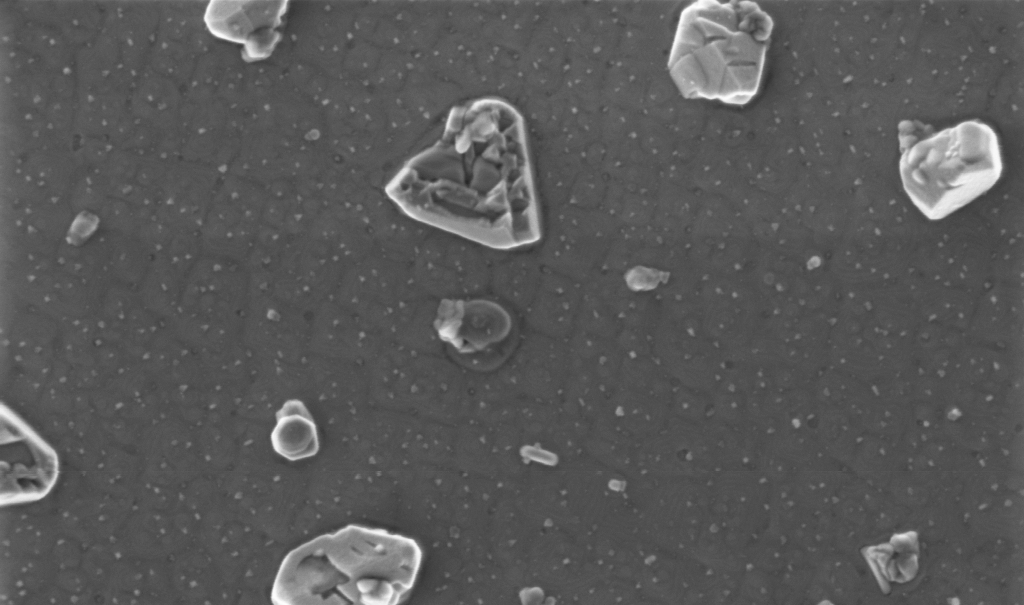

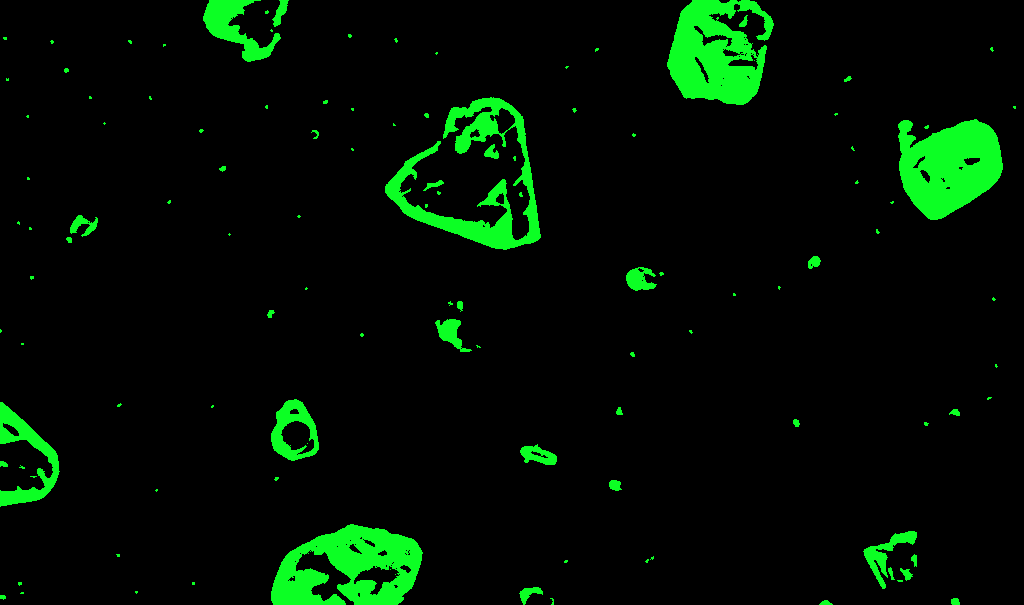

In [ ]:
imagesList, pointsList, sizeList = process(particle, True)
display(imagesList)